<a href="https://colab.research.google.com/github/clustercoder/janus-ids/blob/main/janus_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

Using device: cpu


In [5]:
import pandas as pd
import glob
csv_files = glob.glob('/content/drive/MyDrive/janus-dataset/*.csv')
df_list = [pd.read_csv(f) for f in csv_files]
data = pd.concat(df_list, ignore_index=True)
print("Combined dataset shape:", data.shape)


Combined dataset shape: (2830743, 79)


In [6]:
print(data.columns.tolist())

[' Destination Port', ' Flow Duration', ' Total Fwd Packets', ' Total Backward Packets', 'Total Length of Fwd Packets', ' Total Length of Bwd Packets', ' Fwd Packet Length Max', ' Fwd Packet Length Min', ' Fwd Packet Length Mean', ' Fwd Packet Length Std', 'Bwd Packet Length Max', ' Bwd Packet Length Min', ' Bwd Packet Length Mean', ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s', ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min', 'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max', ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std', ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length', ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s', ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean', ' Packet Length Std', ' Packet Length Variance', 'FIN Flag Count', ' SYN Flag Count', ' RST Flag Count', ' PSH Flag Count', ' ACK Flag Count', ' URG Flag 

In [7]:
data.columns = data.columns.str.strip()
print(data.columns.tolist()[:10])  # check first 10


['Destination Port', 'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets', 'Total Length of Fwd Packets', 'Total Length of Bwd Packets', 'Fwd Packet Length Max', 'Fwd Packet Length Min', 'Fwd Packet Length Mean', 'Fwd Packet Length Std']


In [8]:
import numpy as np

data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

print("Dataset shape after cleaning:", data.shape)


Dataset shape after cleaning: (2827876, 79)


In [9]:
print(data['Label'].value_counts().head(2830743))


Label
BENIGN                        2271320
DoS Hulk                       230124
PortScan                       158804
DDoS                           128025
DoS GoldenEye                   10293
FTP-Patator                      7935
SSH-Patator                      5897
DoS slowloris                    5796
DoS Slowhttptest                 5499
Bot                              1956
Web Attack � Brute Force         1507
Web Attack � XSS                  652
Infiltration                       36
Web Attack � Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


In [10]:
# Binary encoding: 0 = Benign, 1 = Attack
data['Attack'] = data['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [11]:
X = data.drop(['Label', 'Attack'], axis=1)
y = data['Attack']


In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

print("Feature matrix shape:", X_scaled.shape)


Feature matrix shape: (2827876, 78)


In [13]:
X_malicious = X_scaled[y == 1]
print("Malicious sample shape:", X_malicious.shape)


Malicious sample shape: (556556, 78)


In [14]:
subset_size = 200_000
X_malicious = X_malicious[np.random.choice(X_malicious.shape[0], subset_size, replace=False)]
print("Subset shape:", X_malicious.shape)


Subset shape: (200000, 78)


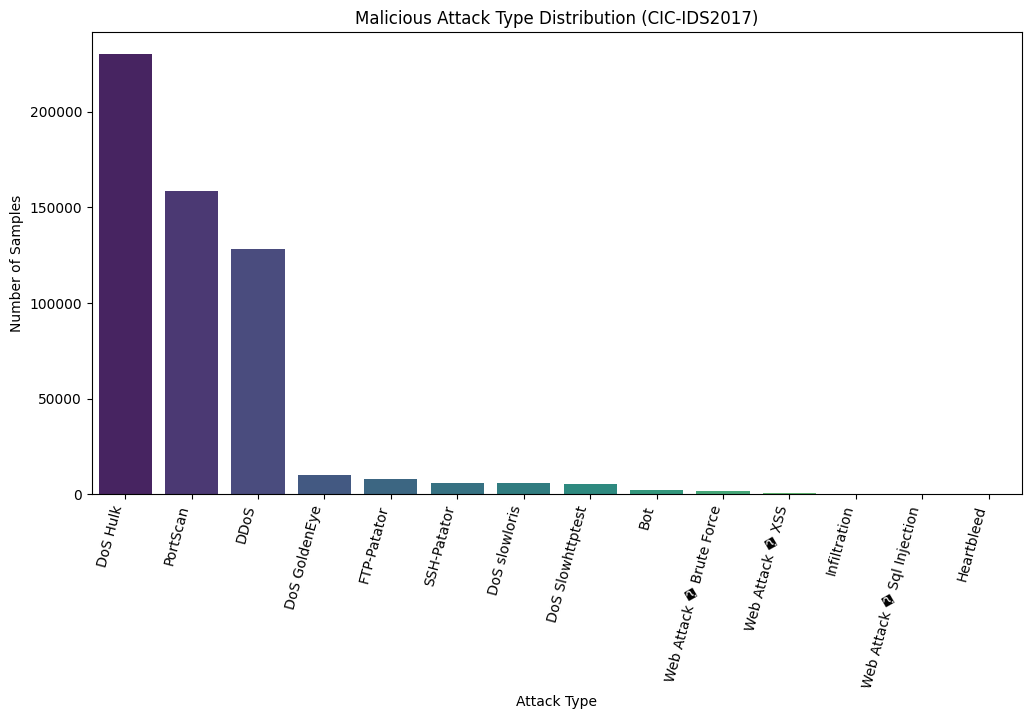

In [15]:
# Attack-only label counts
attack_counts = data[data['Attack'] == 1]['Label'].value_counts()

plt.figure(figsize=(12,6))
sns.barplot(x=attack_counts.index, y=attack_counts.values, palette="viridis")
plt.xticks(rotation=75, ha='right')
plt.title("Malicious Attack Type Distribution (CIC-IDS2017)")
plt.ylabel("Number of Samples")
plt.xlabel("Attack Type")
plt.show()


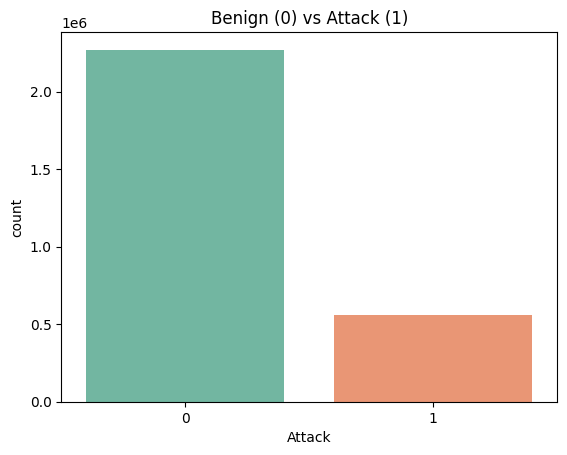

In [16]:
sns.countplot(x='Attack', data=data, palette="Set2")
plt.title("Benign (0) vs Attack (1)")
plt.show()


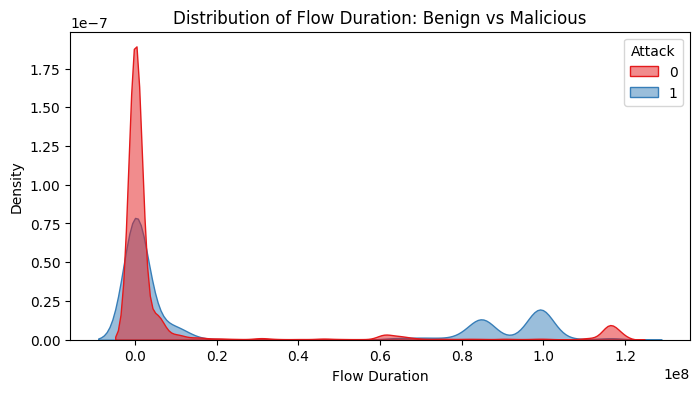

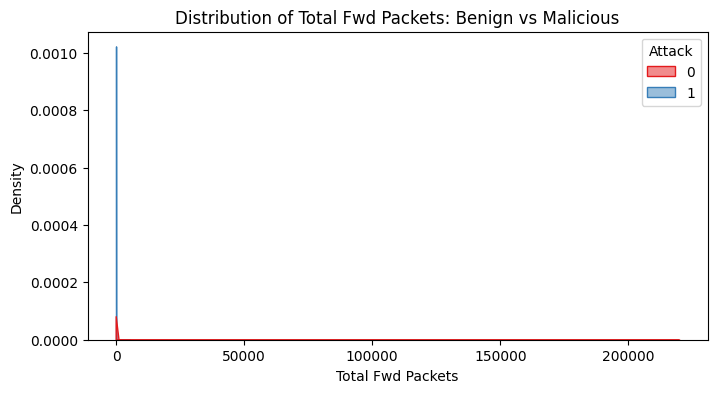

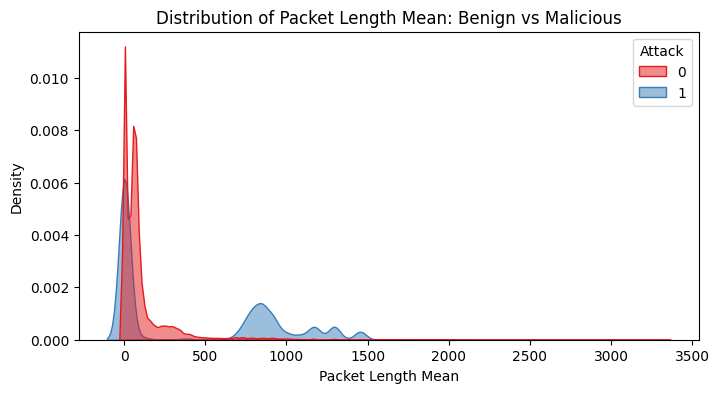

In [17]:
features_to_plot = ['Flow Duration', 'Total Fwd Packets', 'Packet Length Mean']

for feat in features_to_plot:
    plt.figure(figsize=(8,4))
    sns.kdeplot(data=data, x=feat, hue='Attack', common_norm=False, fill=True, palette="Set1", alpha=0.5)
    plt.title(f"Distribution of {feat}: Benign vs Malicious")
    plt.show()


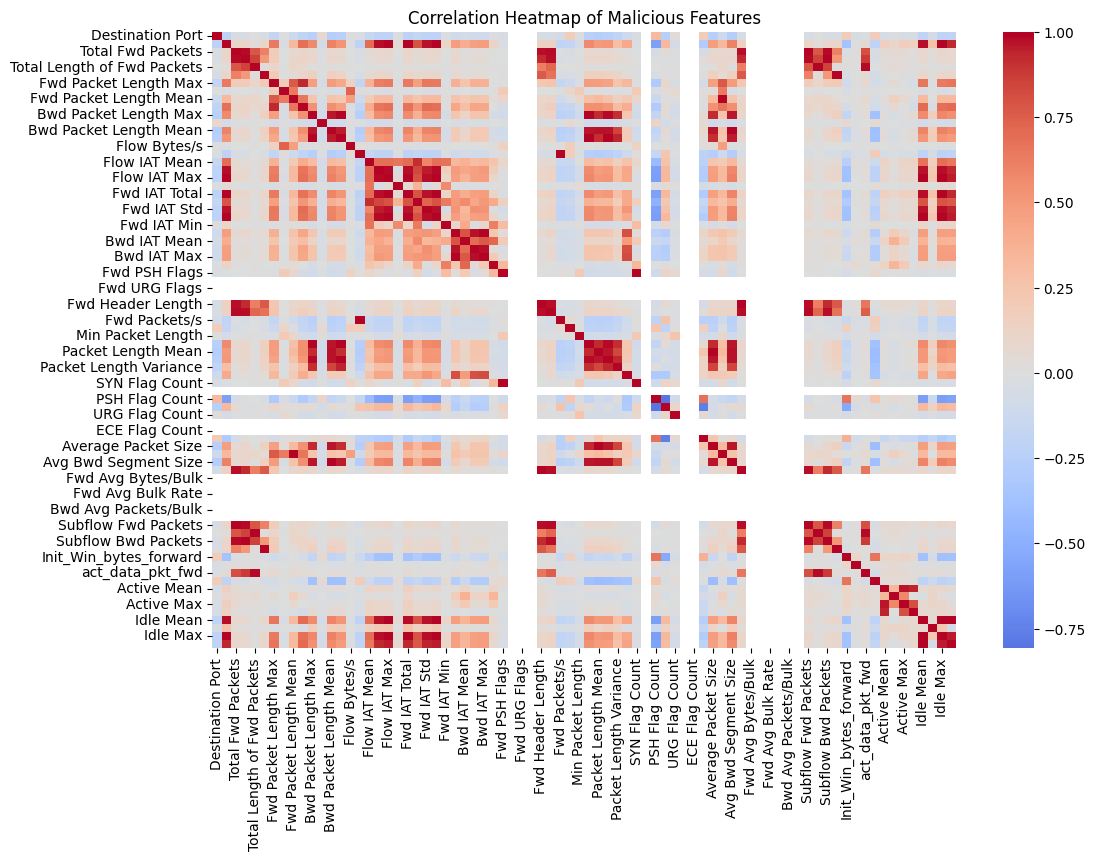

In [18]:
plt.figure(figsize=(12,8))
corr = pd.DataFrame(X_malicious, columns=X.columns).corr()
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap of Malicious Features")
plt.show()


In [19]:
import os, random, math, time
import numpy as np, torch
from torch.utils.data import DataLoader, TensorDataset

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)



print("X_malicious shape (expects (N, features)):", X_malicious.shape)
n_samples, n_features = X_malicious.shape

batch_size = 512
dataset = TensorDataset(torch.tensor(X_malicious, dtype=torch.float32))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

print("Batches per epoch:", len(dataloader))


Device: cpu
X_malicious shape (expects (N, features)): (200000, 78)
Batches per epoch: 390


In [20]:
import torch.nn as nn

latent_dim = 128
hidden_dim = 256
leaky_slope = 0.2

class Generator(nn.Module):
    def __init__(self, z_dim, hidden_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(inplace=True),

            nn.Linear(hidden_dim, int(hidden_dim/2)),
            nn.ReLU(inplace=True),

            nn.Linear(int(hidden_dim/2), output_dim),
            nn.Sigmoid()
        )
    def forward(self, z):
        return self.net(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(0.2),

            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(0.2),

            nn.Linear(hidden_dim, int(hidden_dim/2)),
            nn.LeakyReLU(leaky_slope, inplace=True),
            nn.Dropout(0.2),

            nn.Linear(int(hidden_dim/2), 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

G = Generator(latent_dim, hidden_dim, n_features).to(device)
D = Discriminator(n_features, hidden_dim).to(device)

print("Generator parameters:", sum(p.numel() for p in G.parameters()))
print("Discriminator parameters:", sum(p.numel() for p in D.parameters()))


Generator parameters: 142798
Discriminator parameters: 119041


In [21]:
criterion = nn.BCELoss()

lr = 2e-4
beta1, beta2 = 0.5, 0.999
g_optimizer = torch.optim.Adam(G.parameters(), lr=lr, betas=(beta1, beta2))
d_optimizer = torch.optim.Adam(D.parameters(), lr=lr, betas=(beta1, beta2))

real_label_value = 1.0
fake_label_value = 0.0

use_label_smoothing = True
smooth_real_min = 0.8
smooth_real_max = 1.0


Epoch 1/60: 100%|██████████| 390/390 [00:29<00:00, 13.16it/s, d_loss=0.6873, g_loss=1.9047]


Epoch [1/60]  avg_d_loss: 0.9712  avg_g_loss: 1.5069


Epoch 2/60: 100%|██████████| 390/390 [00:29<00:00, 13.18it/s, d_loss=0.9885, g_loss=1.3108]


Epoch [2/60]  avg_d_loss: 1.0703  avg_g_loss: 1.3076


Epoch 3/60: 100%|██████████| 390/390 [00:28<00:00, 13.51it/s, d_loss=1.0065, g_loss=1.3801]


Epoch [3/60]  avg_d_loss: 1.0569  avg_g_loss: 1.2837


Epoch 4/60: 100%|██████████| 390/390 [00:29<00:00, 13.24it/s, d_loss=1.1635, g_loss=1.2946]


Epoch [4/60]  avg_d_loss: 1.0570  avg_g_loss: 1.3025


Epoch 5/60: 100%|██████████| 390/390 [00:29<00:00, 13.33it/s, d_loss=1.0448, g_loss=1.2224]


Epoch [5/60]  avg_d_loss: 1.0446  avg_g_loss: 1.3145


Epoch 6/60: 100%|██████████| 390/390 [00:28<00:00, 13.48it/s, d_loss=1.1173, g_loss=1.2239]


Epoch [6/60]  avg_d_loss: 1.0700  avg_g_loss: 1.2607


Epoch 7/60: 100%|██████████| 390/390 [00:28<00:00, 13.63it/s, d_loss=1.1029, g_loss=1.1659]


Epoch [7/60]  avg_d_loss: 1.0936  avg_g_loss: 1.2618


Epoch 8/60: 100%|██████████| 390/390 [00:28<00:00, 13.68it/s, d_loss=1.6259, g_loss=1.5617]


Epoch [8/60]  avg_d_loss: 1.0903  avg_g_loss: 1.2869


Epoch 9/60: 100%|██████████| 390/390 [00:28<00:00, 13.78it/s, d_loss=1.0138, g_loss=1.4129]


Epoch [9/60]  avg_d_loss: 1.0593  avg_g_loss: 1.3612


Epoch 10/60: 100%|██████████| 390/390 [00:28<00:00, 13.76it/s, d_loss=0.9687, g_loss=1.8146]


Epoch [10/60]  avg_d_loss: 1.0102  avg_g_loss: 1.5083
Saved checkpoint: /content/drive/MyDrive/janus-checkpoints/gan_epoch_10.pt


Epoch 11/60: 100%|██████████| 390/390 [00:28<00:00, 13.60it/s, d_loss=0.8786, g_loss=1.6064]


Epoch [11/60]  avg_d_loss: 0.9677  avg_g_loss: 1.6334


Epoch 12/60: 100%|██████████| 390/390 [00:28<00:00, 13.63it/s, d_loss=1.1630, g_loss=1.7345]


Epoch [12/60]  avg_d_loss: 0.9363  avg_g_loss: 1.8024


Epoch 13/60: 100%|██████████| 390/390 [00:28<00:00, 13.68it/s, d_loss=1.0831, g_loss=1.4377]


Epoch [13/60]  avg_d_loss: 1.1123  avg_g_loss: 1.3214


Epoch 14/60: 100%|██████████| 390/390 [00:29<00:00, 13.44it/s, d_loss=1.1627, g_loss=1.1352]


Epoch [14/60]  avg_d_loss: 1.2234  avg_g_loss: 1.1890


Epoch 15/60: 100%|██████████| 390/390 [00:28<00:00, 13.66it/s, d_loss=1.0647, g_loss=1.5545]


Epoch [15/60]  avg_d_loss: 1.1149  avg_g_loss: 1.3054


Epoch 16/60: 100%|██████████| 390/390 [00:28<00:00, 13.83it/s, d_loss=1.0949, g_loss=1.4489]


Epoch [16/60]  avg_d_loss: 1.1247  avg_g_loss: 1.3545


Epoch 17/60: 100%|██████████| 390/390 [00:28<00:00, 13.75it/s, d_loss=1.1356, g_loss=1.3261]


Epoch [17/60]  avg_d_loss: 1.0990  avg_g_loss: 1.4278


Epoch 18/60: 100%|██████████| 390/390 [00:29<00:00, 13.06it/s, d_loss=1.1071, g_loss=1.4441]


Epoch [18/60]  avg_d_loss: 1.0929  avg_g_loss: 1.4543


Epoch 19/60: 100%|██████████| 390/390 [00:28<00:00, 13.81it/s, d_loss=1.0518, g_loss=1.6849]


Epoch [19/60]  avg_d_loss: 1.0751  avg_g_loss: 1.4414


Epoch 20/60: 100%|██████████| 390/390 [00:28<00:00, 13.60it/s, d_loss=0.9739, g_loss=1.4919]


Epoch [20/60]  avg_d_loss: 1.0546  avg_g_loss: 1.5406
Saved checkpoint: /content/drive/MyDrive/janus-checkpoints/gan_epoch_20.pt


Epoch 21/60: 100%|██████████| 390/390 [00:28<00:00, 13.51it/s, d_loss=1.0526, g_loss=1.7965]


Epoch [21/60]  avg_d_loss: 1.0388  avg_g_loss: 1.6030


Epoch 22/60: 100%|██████████| 390/390 [00:28<00:00, 13.59it/s, d_loss=0.9209, g_loss=2.3894]


Epoch [22/60]  avg_d_loss: 1.0243  avg_g_loss: 1.6573


Epoch 23/60: 100%|██████████| 390/390 [00:28<00:00, 13.49it/s, d_loss=0.9845, g_loss=1.9139]


Epoch [23/60]  avg_d_loss: 0.9987  avg_g_loss: 1.7507


Epoch 24/60: 100%|██████████| 390/390 [00:28<00:00, 13.60it/s, d_loss=1.1052, g_loss=1.9507]


Epoch [24/60]  avg_d_loss: 0.9911  avg_g_loss: 1.8068


Epoch 25/60: 100%|██████████| 390/390 [00:28<00:00, 13.67it/s, d_loss=0.9710, g_loss=2.1180]


Epoch [25/60]  avg_d_loss: 0.9839  avg_g_loss: 1.8406


Epoch 26/60: 100%|██████████| 390/390 [00:28<00:00, 13.50it/s, d_loss=1.0664, g_loss=1.7457]


Epoch [26/60]  avg_d_loss: 0.9916  avg_g_loss: 1.8420


Epoch 27/60: 100%|██████████| 390/390 [00:28<00:00, 13.62it/s, d_loss=1.0789, g_loss=1.9242]


Epoch [27/60]  avg_d_loss: 0.9870  avg_g_loss: 1.8680


Epoch 28/60: 100%|██████████| 390/390 [00:28<00:00, 13.77it/s, d_loss=0.8163, g_loss=2.1247]


Epoch [28/60]  avg_d_loss: 0.9765  avg_g_loss: 1.9048


Epoch 29/60: 100%|██████████| 390/390 [00:28<00:00, 13.57it/s, d_loss=0.9129, g_loss=2.4313]


Epoch [29/60]  avg_d_loss: 0.9844  avg_g_loss: 1.9561


Epoch 30/60: 100%|██████████| 390/390 [00:28<00:00, 13.55it/s, d_loss=0.8338, g_loss=2.0122]


Epoch [30/60]  avg_d_loss: 0.9742  avg_g_loss: 1.9762
Saved checkpoint: /content/drive/MyDrive/janus-checkpoints/gan_epoch_30.pt


Epoch 31/60: 100%|██████████| 390/390 [00:28<00:00, 13.50it/s, d_loss=1.0212, g_loss=3.1698]


Epoch [31/60]  avg_d_loss: 0.9733  avg_g_loss: 1.9536


Epoch 32/60: 100%|██████████| 390/390 [00:28<00:00, 13.57it/s, d_loss=0.9373, g_loss=1.7881]


Epoch [32/60]  avg_d_loss: 0.9736  avg_g_loss: 1.9701


Epoch 33/60: 100%|██████████| 390/390 [00:28<00:00, 13.51it/s, d_loss=0.8459, g_loss=2.1742]


Epoch [33/60]  avg_d_loss: 0.9930  avg_g_loss: 1.9155


Epoch 34/60: 100%|██████████| 390/390 [00:28<00:00, 13.57it/s, d_loss=1.3458, g_loss=0.8593]


Epoch [34/60]  avg_d_loss: 0.9931  avg_g_loss: 1.9635


Epoch 35/60: 100%|██████████| 390/390 [00:28<00:00, 13.60it/s, d_loss=0.9143, g_loss=2.0122]


Epoch [35/60]  avg_d_loss: 0.9802  avg_g_loss: 1.9998


Epoch 36/60: 100%|██████████| 390/390 [00:29<00:00, 13.43it/s, d_loss=0.9799, g_loss=2.4091]


Epoch [36/60]  avg_d_loss: 0.9940  avg_g_loss: 1.9620


Epoch 37/60: 100%|██████████| 390/390 [00:28<00:00, 13.50it/s, d_loss=1.0530, g_loss=1.0473]


Epoch [37/60]  avg_d_loss: 0.9904  avg_g_loss: 1.9756


Epoch 38/60: 100%|██████████| 390/390 [00:28<00:00, 13.47it/s, d_loss=1.0032, g_loss=1.5298]


Epoch [38/60]  avg_d_loss: 0.9964  avg_g_loss: 1.9537


Epoch 39/60: 100%|██████████| 390/390 [00:29<00:00, 13.24it/s, d_loss=0.8636, g_loss=2.8089]


Epoch [39/60]  avg_d_loss: 0.9820  avg_g_loss: 2.0248


Epoch 40/60: 100%|██████████| 390/390 [00:28<00:00, 13.59it/s, d_loss=0.6781, g_loss=2.8262]


Epoch [40/60]  avg_d_loss: 0.9903  avg_g_loss: 1.9890
Saved checkpoint: /content/drive/MyDrive/janus-checkpoints/gan_epoch_40.pt


Epoch 41/60: 100%|██████████| 390/390 [00:28<00:00, 13.70it/s, d_loss=1.0676, g_loss=2.2175]


Epoch [41/60]  avg_d_loss: 0.9900  avg_g_loss: 2.0171


Epoch 42/60: 100%|██████████| 390/390 [00:28<00:00, 13.50it/s, d_loss=0.7481, g_loss=2.9075]


Epoch [42/60]  avg_d_loss: 0.9751  avg_g_loss: 2.0538


Epoch 43/60: 100%|██████████| 390/390 [00:28<00:00, 13.56it/s, d_loss=0.9690, g_loss=1.8243]


Epoch [43/60]  avg_d_loss: 0.9977  avg_g_loss: 2.0190


Epoch 44/60: 100%|██████████| 390/390 [00:28<00:00, 13.69it/s, d_loss=1.0696, g_loss=1.5082]


Epoch [44/60]  avg_d_loss: 0.9939  avg_g_loss: 2.0265


Epoch 45/60: 100%|██████████| 390/390 [00:28<00:00, 13.66it/s, d_loss=1.0543, g_loss=1.6499]


Epoch [45/60]  avg_d_loss: 0.9916  avg_g_loss: 2.0436


Epoch 46/60: 100%|██████████| 390/390 [00:28<00:00, 13.63it/s, d_loss=1.0065, g_loss=2.1391]


Epoch [46/60]  avg_d_loss: 1.0134  avg_g_loss: 1.9503


Epoch 47/60: 100%|██████████| 390/390 [00:28<00:00, 13.59it/s, d_loss=0.8646, g_loss=2.2604]


Epoch [47/60]  avg_d_loss: 1.0044  avg_g_loss: 1.9910


Epoch 48/60: 100%|██████████| 390/390 [00:28<00:00, 13.46it/s, d_loss=1.1485, g_loss=2.5139]


Epoch [48/60]  avg_d_loss: 1.0047  avg_g_loss: 1.9916


Epoch 49/60: 100%|██████████| 390/390 [00:28<00:00, 13.59it/s, d_loss=1.0673, g_loss=1.6137]


Epoch [49/60]  avg_d_loss: 1.0068  avg_g_loss: 1.9638


Epoch 50/60: 100%|██████████| 390/390 [00:28<00:00, 13.77it/s, d_loss=0.9845, g_loss=1.8831]


Epoch [50/60]  avg_d_loss: 1.0016  avg_g_loss: 2.0469
Saved checkpoint: /content/drive/MyDrive/janus-checkpoints/gan_epoch_50.pt


Epoch 51/60: 100%|██████████| 390/390 [00:29<00:00, 13.44it/s, d_loss=1.2459, g_loss=1.6004]


Epoch [51/60]  avg_d_loss: 1.0219  avg_g_loss: 1.9549


Epoch 52/60: 100%|██████████| 390/390 [00:28<00:00, 13.56it/s, d_loss=1.0898, g_loss=1.8027]


Epoch [52/60]  avg_d_loss: 1.0257  avg_g_loss: 1.9177


Epoch 53/60: 100%|██████████| 390/390 [00:28<00:00, 13.54it/s, d_loss=0.8424, g_loss=2.2952]


Epoch [53/60]  avg_d_loss: 1.0163  avg_g_loss: 1.9475


Epoch 54/60: 100%|██████████| 390/390 [00:29<00:00, 13.42it/s, d_loss=1.0451, g_loss=1.5877]


Epoch [54/60]  avg_d_loss: 1.0278  avg_g_loss: 1.9244


Epoch 55/60: 100%|██████████| 390/390 [00:28<00:00, 13.66it/s, d_loss=1.1082, g_loss=1.9490]


Epoch [55/60]  avg_d_loss: 1.0423  avg_g_loss: 1.8235


Epoch 56/60: 100%|██████████| 390/390 [00:28<00:00, 13.61it/s, d_loss=0.9896, g_loss=1.8415]


Epoch [56/60]  avg_d_loss: 1.0249  avg_g_loss: 1.9476


Epoch 57/60: 100%|██████████| 390/390 [00:28<00:00, 13.72it/s, d_loss=1.2636, g_loss=1.1652]


Epoch [57/60]  avg_d_loss: 1.0374  avg_g_loss: 1.8648


Epoch 58/60: 100%|██████████| 390/390 [00:28<00:00, 13.58it/s, d_loss=1.2343, g_loss=1.0815]


Epoch [58/60]  avg_d_loss: 1.0429  avg_g_loss: 1.8615


Epoch 59/60: 100%|██████████| 390/390 [00:28<00:00, 13.62it/s, d_loss=0.9077, g_loss=4.7244]


Epoch [59/60]  avg_d_loss: 1.0424  avg_g_loss: 1.8656


Epoch 60/60: 100%|██████████| 390/390 [00:28<00:00, 13.59it/s, d_loss=1.1158, g_loss=1.0921]


Epoch [60/60]  avg_d_loss: 1.0452  avg_g_loss: 1.8473
Saved checkpoint: /content/drive/MyDrive/janus-checkpoints/gan_epoch_60.pt


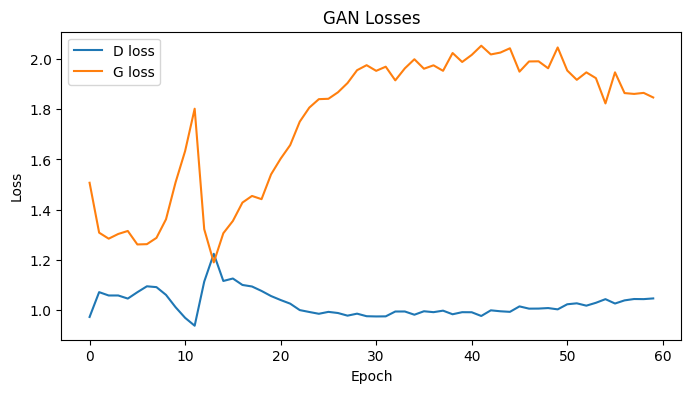

In [22]:
from tqdm import tqdm
import matplotlib.pyplot as plt

num_epochs = 60
log_every = 50

G.train(); D.train()
g_losses = []
d_losses = []
it = 0

for epoch in range(num_epochs):
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")
    for i, (real_batch,) in pbar:
        bs = real_batch.size(0)
        real_batch = real_batch.to(device)

        # --- Train Discriminator ---
        D.zero_grad()
        # real
        if use_label_smoothing:
            real_labels = torch.empty(bs, device=device).uniform_(smooth_real_min, smooth_real_max)
        else:
            real_labels = torch.full((bs,), real_label_value, device=device)
        out_real = D(real_batch).view(-1)
        d_loss_real = criterion(out_real, real_labels)

        # fake
        noise = torch.randn(bs, latent_dim, device=device)
        fake = G(noise)
        fake_labels = torch.full((bs,), fake_label_value, device=device)
        out_fake = D(fake.detach()).view(-1)
        d_loss_fake = criterion(out_fake, fake_labels)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        d_optimizer.step()

        # --- Train Generator ---
        G.zero_grad()
        noise = torch.randn(bs, latent_dim, device=device)
        gen = G(noise)
        target_labels = torch.full((bs,), real_label_value, device=device)
        g_out = D(gen).view(-1)
        g_loss = criterion(g_out, target_labels)
        g_loss.backward()
        g_optimizer.step()

        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        it += 1

        if (i+1) % log_every == 0:
            pbar.set_postfix({'d_loss': f"{d_loss.item():.4f}", 'g_loss': f"{g_loss.item():.4f}"})

    avg_d = epoch_d_loss / len(dataloader)
    avg_g = epoch_g_loss / len(dataloader)
    d_losses.append(avg_d)
    g_losses.append(avg_g)
    print(f"Epoch [{epoch+1}/{num_epochs}]  avg_d_loss: {avg_d:.4f}  avg_g_loss: {avg_g:.4f}")

    if (epoch+1) % 10 == 0:
        ckpt_dir = "/content/drive/MyDrive/janus-checkpoints"
        os.makedirs(ckpt_dir, exist_ok=True)
        torch.save({'epoch': epoch+1, 'G_state': G.state_dict(), 'D_state': D.state_dict(),
                    'g_optimizer': g_optimizer.state_dict(), 'd_optimizer': d_optimizer.state_dict()},
                   os.path.join(ckpt_dir, f"gan_epoch_{epoch+1}.pt"))
        print("Saved checkpoint:", os.path.join(ckpt_dir, f"gan_epoch_{epoch+1}.pt"))

plt.figure(figsize=(8,4))
plt.plot(d_losses, label='D loss')
plt.plot(g_losses, label='G loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("GAN Losses")
plt.show()


In [23]:
G.eval()
n_gen = 5000
with torch.no_grad():
    n_batches = math.ceil(n_gen / 1024)
    gen_list = []
    for _ in range(n_batches):
        z = torch.randn(min(1024, n_gen), latent_dim, device=device)
        gen_batch = G(z).cpu().numpy()
        gen_list.append(gen_batch)
        n_gen -= gen_batch.shape[0]
gen_synth = np.vstack(gen_list)[:5000]
print("Generated synth shape (scaled):", gen_synth.shape)

try:
    synth_original_scale = scaler.inverse_transform(gen_synth)
    print("Inverse transformed. Sample (first row):")
    print(synth_original_scale[0])
except Exception as e:
    print("Could not inverse-transform (scaler missing or incompatible):", e)
    synth_original_scale = gen_synth

out_path = "/content/drive/MyDrive/janus-generated/synth_attack_samples.csv"
os.makedirs(os.path.dirname(out_path), exist_ok=True)
import pandas as pd
df_synth = pd.DataFrame(synth_original_scale, columns=X.columns)
df_synth.to_csv(out_path, index=False)
print("Saved generated samples to:", out_path)


Generated synth shape (scaled): (5000, 78)
Inverse transformed. Sample (first row):
[ 7.21301880e+01  4.80942750e+05  1.85836196e+00  8.47906712e-03
  2.16318801e-01  1.22932110e+01  1.47527516e+00  1.77008522e+00
  2.25942421e+00  1.10082015e-01  3.18397164e+00  6.22685477e-02
  4.68597025e-01  8.66246223e-01  1.11111130e+07  1.61905889e+04
  5.97126289e+04  1.55071359e+05  4.37783719e+05  2.72522552e+02
  4.39870844e+05  1.15307648e+05  2.15322125e+05  4.19515219e+05
  5.76142883e+01  1.55903870e+02  2.58700848e+00  4.14933872e+00
  3.03958511e+01  5.29292236e+02  4.10527946e-06  1.09026434e-11
  1.65416357e-12  4.69438594e-12 -1.93950220e+07 -3.14698150e+06
  9.55786230e+03  2.24991870e+00  1.11209130e+00  2.05844879e+00
  7.60744631e-01  3.60370189e-01  1.44881226e+03  2.41356393e-05
  1.76005437e-06  8.36033586e-12  1.15082743e-09  1.00000000e+00
  4.11326795e-07  3.01778264e-12  4.53799411e-12  1.02159241e-03
  6.74462736e-01  1.34242618e+00  5.12793362e-01  4.64490800e+06
  7.38

In [24]:
real_mean = X_malicious.mean(axis=0)
real_std = X_malicious.std(axis=0)
gen_mean = gen_synth.mean(axis=0)
gen_std = gen_synth.std(axis=0)

print("Feature 0 mean (real vs gen):", real_mean[0], gen_mean[0])
print("Feature 0 std  (real vs gen):", real_std[0], gen_std[0])

mean_l2 = np.linalg.norm(real_mean - gen_mean)
print("L2 distance between feature-wise means:", mean_l2)


Feature 0 mean (real vs gen): 0.03902243587389495 0.09111017
Feature 0 std  (real vs gen): 0.12564750375707034 0.19247426
L2 distance between feature-wise means: 0.4462558273754425


In [25]:
from sklearn.model_selection import train_test_split

X_train_all, X_test, y_train_all, y_test = train_test_split(
    X_scaled, y, test_size=0.20, stratify=y, random_state=42
)
print("Train-all shape:", X_train_all.shape, "Test shape:", X_test.shape)



Train-all shape: (2262300, 78) Test shape: (565576, 78)


In [26]:
import torch
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix

def score_with_discriminator(model, X_np, batch=4096):
    model.eval()
    scores = []
    with torch.no_grad():
        for i in range(0, X_np.shape[0], batch):
            batch_x = torch.tensor(X_np[i:i+batch], dtype=torch.float32, device=device)
            out = model(batch_x).view(-1).cpu().numpy()
            scores.append(out)
    return np.concatenate(scores)

d_scores_test = score_with_discriminator(D, X_test)
print("Scores shape:", d_scores_test.shape)


Scores shape: (565576,)


In [27]:
y_test_arr = np.array(y_test).astype(int)

# ROC AUC
roc_auc = roc_auc_score(y_test_arr, d_scores_test)
fpr, tpr, roc_thresh = roc_curve(y_test_arr, d_scores_test)
roc_auc, fpr.shape, tpr.shape

precision, recall, pr_thresh = precision_recall_curve(y_test_arr, d_scores_test)
pr_auc = auc(recall, precision)

print(f"ROC AUC: {roc_auc:.4f}   PR AUC: {pr_auc:.4f}")

youden_j = tpr - fpr
best_idx = np.argmax(youden_j)
best_thresh = roc_thresh[best_idx]
print("Youden best threshold:", best_thresh)

target_fpr = 0.01
if np.any(fpr <= target_fpr):
    thr_idx = np.where(fpr <= target_fpr)[0][-1]
    thr_for_target_fpr = roc_thresh[thr_idx]
    print(f"Threshold achieving FPR <= {target_fpr}: {thr_for_target_fpr}")
else:
    thr_for_target_fpr = best_thresh
    print("No threshold yields that low FPR; using Youden's threshold.")


ROC AUC: 0.5768   PR AUC: 0.2007
Youden best threshold: 0.2172889
Threshold achieving FPR <= 0.01: 0.999970555305481


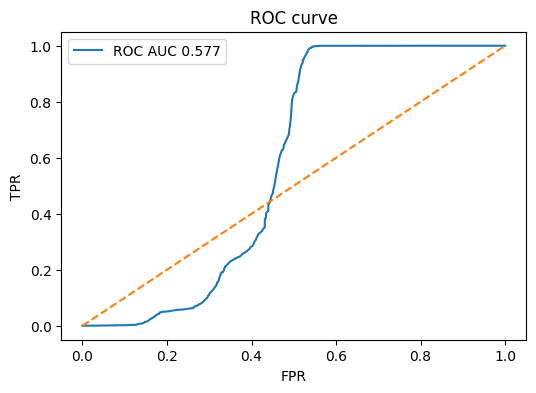

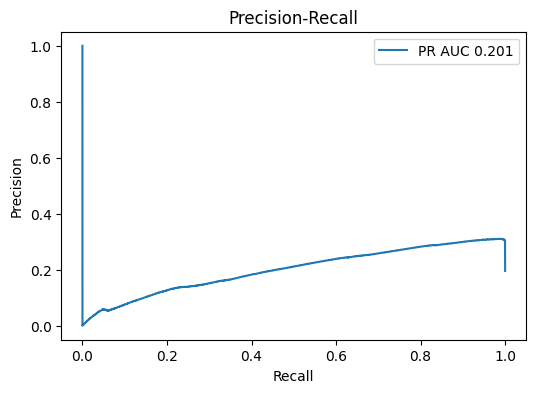

In [28]:
import matplotlib.pyplot as plt
# ROC
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"ROC AUC {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC curve")
plt.legend(); plt.show()

# PR
plt.figure(figsize=(6,4))
plt.plot(recall, precision, label=f"PR AUC {pr_auc:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall")
plt.legend(); plt.show()


In [29]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

threshold = best_thresh
y_pred = (d_scores_test >= threshold).astype(int)

print("Confusion matrix:")
print(confusion_matrix(y_test_arr, y_pred))

print("Accuracy", accuracy_score(y_test_arr, y_pred))
print("Precision", precision_score(y_test_arr, y_pred))
print("Recall", recall_score(y_test_arr, y_pred))
print("F1", f1_score(y_test_arr, y_pred))


Confusion matrix:
[[210502 243763]
 [  1126 110185]]
Accuracy 0.5670095619333211
Precision 0.31130279024037427
Recall 0.9898841983272093
F1 0.47365016044826647


In [30]:
unseen_labels = ['Heartbleed', 'Infiltration']
mask_unseen = data['Label'].isin(unseen_labels)
X_unseen = scaler.transform(data.loc[mask_unseen, X.columns].values)   # scaled
y_unseen = (data.loc[mask_unseen, 'Label'] != 'BENIGN').astype(int)

scores_unseen = score_with_discriminator(D, X_unseen)
print("Unseen set size:", X_unseen.shape[0])
print("Mean D-score on unseen attacks:", scores_unseen.mean())


Unseen set size: 47
Mean D-score on unseen attacks: 0.91706514


In [31]:
ckpt_dir = "/content/drive/MyDrive/janus-checkpoints"
os.makedirs(ckpt_dir, exist_ok=True)
torch.save(G.state_dict(), os.path.join(ckpt_dir, "G_final.pth"))
torch.save(D.state_dict(), os.path.join(ckpt_dir, "D_final.pth"))

import joblib
joblib.dump(scaler, os.path.join(ckpt_dir, "minmax_scaler.gz"))

print("Saved G, D, scaler to:", ckpt_dir)

G2 = Generator(latent_dim, hidden_dim, n_features).to(device)
D2 = Discriminator(n_features, hidden_dim).to(device)
G2.load_state_dict(torch.load(os.path.join(ckpt_dir, "G_final.pth")))
D2.load_state_dict(torch.load(os.path.join(ckpt_dir, "D_final.pth")))
scaler2 = joblib.load(os.path.join(ckpt_dir, "minmax_scaler.gz"))
G2.eval(); D2.eval()


Saved G, D, scaler to: /content/drive/MyDrive/janus-checkpoints


Discriminator(
  (net): Sequential(
    (0): Linear(in_features=78, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=256, bias=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Dropout(p=0.2, inplace=False)
    (9): Linear(in_features=128, out_features=1, bias=True)
    (10): Sigmoid()
  )
)

In [35]:
def detect_flow(model, scaler, flow_df_row, threshold):

    model.eval()
    x = np.array(flow_df_row).reshape(1, -1)
    x_scaled = scaler.transform(x)
    score = score_with_discriminator(model, x_scaled, batch=1)[0]
    return score, (score >= threshold)

row = X.iloc[0]
score, is_attack = detect_flow(D, scaler, row.values, threshold)
print(score,is_attack)


0.40232822 True


In [36]:
real_mean = X_malicious.mean(axis=0)
gen_mean = gen_synth.mean(axis=0)
real_std = X_malicious.std(axis=0)
gen_std = gen_synth.std(axis=0)

print("Mean L2 distance:", np.linalg.norm(real_mean - gen_mean))
print("Std L2 distance:", np.linalg.norm(real_std - gen_std))


Mean L2 distance: 0.4462558273754425
Std L2 distance: 0.5770327222482247
